# Определение перспективного тарифа для телеком компании

Цель - исследовать поведение пользователей сотового оператора и найти оптимальный тариф. 

Задачи: 
- Привести данные к нужным типам, исправить ошибки где нужно
- Для каждого пользователя посчитать количество звонков , минут, смс, гб, выручку. 
- Посчитать среднее количество, дисперсию и стандартное отклонение. 
- Построить гистограммы. 
- Проверить гипотезу о различии средней выручки между двумя тарифами, а также между пользователями столицы и регионов.

# Общая информация о данных

Выгрузим данные и посмотрим на них. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st

In [4]:
pd.set_option('display.max_columns', 500)

In [5]:
calls = pd.read_csv('calls.csv') 

In [6]:
calls.sample(5)

,id,call_date,duration,user_id
108743,1281_176,2018-12-18,14.01,1281
54776,1138_201,2018-09-21,9.31,1138
103181,1264_320,2018-04-24,0.00,1264
74436,1186_258,2018-08-10,13.89,1186
152197,1379_432,2018-09-15,22.05,1379


In [7]:
internet = pd.read_csv('internet.csv')

In [8]:
messages = pd.read_csv('messages.csv')

In [9]:
tariffs = pd.read_csv('tariffs.csv')

In [10]:
users = pd.read_csv('users.csv')

In [11]:
internet.sample()

,Unnamed: 0,id,mb_used,session_date,user_id
17051,17051,1059_57,413.4,2018-04-22,1059


In [12]:
messages.sample()

,id,message_date,user_id
52169,1231_790,2018-09-24,1231


In [13]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [14]:
users.sample()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
480,1480,29,2018-09-26,Новокузнецк,Гелена,Емельянова,2018-02-14,smart


# Подготовка данных

Приведем данные к нужным типам; найдем и исправим ошибки в данных.

Посчитаем для каждого пользователя:

    количество сделанных звонков и израсходованных минут разговора по месяцам;
    количество отправленных сообщений по месяцам;
    объем израсходованного интернет-трафика по месяцам;
    помесячную выручку с каждого пользователя.

## Звонки

In [15]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [16]:
calls.sample(10)

,id,call_date,duration,user_id
114418,1292_175,2018-05-04,6.60,1292
49290,1123_309,2018-03-24,0.00,1123
188858,1465_575,2018-09-28,9.49,1465
59445,1148_908,2018-05-27,0.00,1148
141936,1360_379,2018-10-29,8.37,1360
71793,1179_65,2018-07-24,11.78,1179
28869,1072_195,2018-05-21,11.24,1072
166841,1411_256,2018-07-22,0.06,1411
45150,1113_566,2018-05-03,5.77,1113
87105,1218_222,2018-11-04,20.04,1218


Переведем колонку с датами в формат даты.

In [17]:
calls['call_date']= pd.to_datetime(calls['call_date'], format='%Y-%m-%d')

In [18]:
calls.sample(3)

,id,call_date,duration,user_id
170664,1421_227,2018-04-13,13.97,1421
134534,1344_351,2018-09-21,0.00,1344
68983,1174_23,2018-06-22,14.53,1174


In [19]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  float64       
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB


In [20]:
calls['call_date'].max()

Timestamp('2018-12-31 00:00:00')

In [21]:
calls['call_date'].min()

Timestamp('2018-01-01 00:00:00')

Посмотрим на распределение продолжительности звонков.

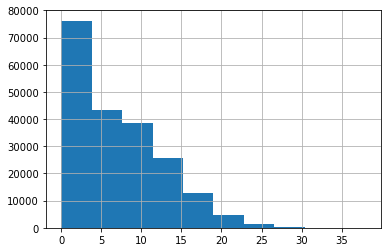

In [22]:
calls['duration'].hist()

In [23]:
calls['duration'].describe()

count    202607.000000
mean          6.755887
std           5.843365
min           0.000000
25%           1.300000
50%           6.000000
75%          10.700000
max          38.000000
Name: duration, dtype: float64

Обратим внимание на нулевые значения.

In [24]:
calls.query('duration == 0').count()

id           39613
call_date    39613
duration     39613
user_id      39613
dtype: int64

In [25]:
calls_no_null= calls.loc[calls['duration'] != 0]

In [26]:
calls_no_null['duration'].describe()

count    162994.000000
mean          8.397794
std           5.353022
min           0.010000
25%           4.170000
50%           7.740000
75%          11.850000
max          38.000000
Name: duration, dtype: float64

Посмотрим на распределение длительности звонков, если не считать нулевые значения.

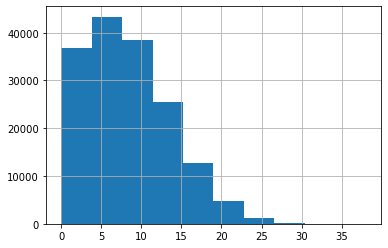

In [27]:
calls_no_null['duration'].hist()

In [28]:
calls.loc[(calls['duration'] < 1)&(calls['duration'] != 0)]

,id,call_date,duration,user_id
55,1000_55,2018-09-19,0.31,1000
65,1000_65,2018-10-28,0.34,1000
97,1000_97,2018-10-26,0.33,1000
122,1000_122,2018-10-07,0.13,1000
135,1000_135,2018-10-25,0.02,1000
...,...,...,...,...
202484,1499_97,2018-12-22,0.07,1499
202537,1499_150,2018-12-09,0.56,1499
202545,1499_158,2018-11-16,0.64,1499
202579,1499_192,2018-12-07,0.76,1499


Мы видим, что если брать в расчет пропущенные звонки (т.е. звонки с 0 секунд), то они сильно смещают медиану длительности звонков: 6 и 7.74; поэтому предлагаю работать с выборкой  звонков без пропущенных звонков. 

In [29]:
calls = calls_no_null

Раз тарификация идёт за минуты с округлением вверх, то и нам стоит перевести значения в столбце с продолжительностью звонков к минутам с округлением вверх.

In [30]:
calls['duration_round']=calls['duration'].apply(np.ceil)
calls.sample()

,id,call_date,duration,user_id,duration_round
115836,1298_336,2018-09-27,11.23,1298,12.0


Посчитаем количество сделанных звонков и израсходованных минут разговора по месяцам для каждого пользователя. 

In [31]:
# Добавим колонку с месяцем. 
calls['month'] = calls['call_date'].values.astype('datetime64[M]')

In [32]:
call_stat = calls.groupby(['user_id', 'month']).agg({'duration_round': ['sum', 'count']}).reset_index() 

In [33]:
call_stat

user_id      month duration_round      
                                   sum count
0       1000 2018-05-01          159.0    17
1       1000 2018-06-01          172.0    28
2       1000 2018-07-01          340.0    41
3       1000 2018-08-01          408.0    42
4       1000 2018-09-01          466.0    46
...      ...        ...            ...   ...
3163    1498 2018-10-01          247.0    30
3164    1499 2018-09-01           70.0     8
3165    1499 2018-10-01          449.0    44
3166    1499 2018-11-01          612.0    62
3167    1499 2018-12-01          492.0    56

[3168 rows x 4 columns]

In [34]:
call_stat.columns=['user_id','month','call_duration','call_count']
call_stat

,user_id,month,call_duration,call_count
0,1000,2018-05-01,159.0,17
1,1000,2018-06-01,172.0,28
2,1000,2018-07-01,340.0,41
3,1000,2018-08-01,408.0,42
4,1000,2018-09-01,466.0,46
...,...,...,...,...
3163,1498,2018-10-01,247.0,30
3164,1499,2018-09-01,70.0,8
3165,1499,2018-10-01,449.0,44
3166,1499,2018-11-01,612.0,62


## Интернет траффик

In [35]:
internet.sample()

,Unnamed: 0,id,mb_used,session_date,user_id
36269,36269,1126_216,32.54,2018-08-29,1126


In [36]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [37]:
# Переведем столбец с датой в нужный формат
internet['month'] = internet['session_date'].values.astype('datetime64[M]')

Посчитаем потраченный траффик для каждого пользователя по месяцам. 

In [38]:
internet_stat = internet.groupby(['user_id', 'month']).agg({'mb_used':'sum'}).reset_index() 
internet_stat

,user_id,month,mb_used
0,1000,2018-05-01,2253.49
1,1000,2018-06-01,23233.77
2,1000,2018-07-01,14003.64
3,1000,2018-08-01,14055.93
4,1000,2018-09-01,14568.91
...,...,...,...
3198,1498,2018-10-01,20579.36
3199,1499,2018-09-01,1845.75
3200,1499,2018-10-01,17788.51
3201,1499,2018-11-01,17963.31


In [39]:
#Переведем мегабайты в гигобайты
internet_stat['gb_used']=internet_stat['mb_used']/1024
internet_stat.head()

,user_id,month,mb_used,gb_used
0,1000,2018-05-01,2253.49,2.200674
1,1000,2018-06-01,23233.77,22.689229
2,1000,2018-07-01,14003.64,13.675430
3,1000,2018-08-01,14055.93,13.726494
4,1000,2018-09-01,14568.91,14.227451


In [40]:
internet_stat['gb_used']=internet_stat['gb_used'].apply(np.ceil)
internet_stat.head()

,user_id,month,mb_used,gb_used
0,1000,2018-05-01,2253.49,3.0
1,1000,2018-06-01,23233.77,23.0
2,1000,2018-07-01,14003.64,14.0
3,1000,2018-08-01,14055.93,14.0
4,1000,2018-09-01,14568.91,15.0


## Смс

In [41]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')

In [42]:
messages['month'] = messages['message_date'].values.astype('datetime64[M]')

In [43]:
messages.sample()

,id,message_date,user_id,month
80226,1335_138,2018-10-06,1335,2018-10-01


Посчитаем количество сообщений для каждого пользователя по месяцам. 

In [44]:
messages_stat = messages.groupby(['user_id', 'month']).agg({'id':'count'}).reset_index()
messages_stat

,user_id,month,id
0,1000,2018-05-01,22
1,1000,2018-06-01,60
2,1000,2018-07-01,75
3,1000,2018-08-01,81
4,1000,2018-09-01,57
...,...,...,...
2712,1498,2018-10-01,42
2713,1499,2018-09-01,11
2714,1499,2018-10-01,48
2715,1499,2018-11-01,59


In [45]:
messages_stat.columns=['user_id','month','messages_count']
messages_stat

,user_id,month,messages_count
0,1000,2018-05-01,22
1,1000,2018-06-01,60
2,1000,2018-07-01,75
3,1000,2018-08-01,81
4,1000,2018-09-01,57
...,...,...,...
2712,1498,2018-10-01,42
2713,1499,2018-09-01,11
2714,1499,2018-10-01,48
2715,1499,2018-11-01,59


## Информация о пользователях

In [46]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [47]:
users.sample(3)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
42,1042,42,NaN,Хабаровск,Константин,Добрынин,2018-11-25,smart
490,1490,30,NaN,Москва,Радомир,Алесин,2018-04-03,smart
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Исправим тип данных в колонке с датами.

In [48]:
users['reg_date']=pd.to_datetime(users['reg_date'], format='%Y-%m-%d')

## Тарифы

In [49]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [50]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [51]:
# Добавим столбик с гб, включенными в тариф, чтобы потом использовать его при подсчете. 
tariffs['gb_per_month_included']=tariffs['mb_per_month_included']/1024
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,gb_per_month_included
0,50,15360,500,550,200,3,3,smart,15.0
1,1000,30720,3000,1950,150,1,1,ultra,30.0


Поменяем название колонки с названием тарифа, чтобы она совпадала с колонкой в таблице с пользователями.

In [52]:
tariffs.columns = ['messages_included','mb_per_month_included','minutes_included','rub_monthly_fee','rub_per_gb','rub_per_message','rub_per_minute','tariff','gb_per_month_included']
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff,gb_per_month_included
0,50,15360,500,550,200,3,3,smart,15.0
1,1000,30720,3000,1950,150,1,1,ultra,30.0


## Выручка с пользователя

Сначала соединим таблицы вместе: таблицы с пользователями и статистику по звонкам, сообщению и потраченному интернет траффику, потом с тарифами. Соединять будем по пользовательскому ай-ди и по колонке с месяцем.

In [53]:
call_stat.sample()

,user_id,month,call_duration,call_count
1388,1219,2018-12-01,447.0,47


In [54]:
df = users.merge(call_stat, on='user_id',how='outer')
df1 = df.merge(internet_stat,on=['user_id','month'],how='outer')
df2 = df1.merge(messages_stat,on=['user_id','month'],how='outer')
df=df2
df.sample(10)
#df1.loc[df['user_id']=='3199']

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,call_duration,call_count,mb_used,gb_used,messages_count
2825,1443,21.0,NaN,Казань,Иван,Афинин,2018-09-17,smart,2018-12-01,611.0,74.0,15746.09,16.0,22.0
877,1142,51.0,NaN,Новосибирск,Симона,Алешкова,2018-03-24,smart,2018-12-01,437.0,53.0,18625.84,19.0,40.0
1406,1223,20.0,NaN,Стерлитамак,Алан,Панфилов,2018-12-12,smart,2018-12-01,651.0,74.0,21556.94,22.0,33.0
2314,1372,71.0,NaN,Магнитогорск,Лидия,Авраамова,2018-01-23,smart,2018-07-01,380.0,45.0,13658.02,14.0,41.0
2360,1377,59.0,NaN,Брянск,Альфред,Семин,2018-02-25,ultra,2018-04-01,1096.0,121.0,1151.05,2.0,17.0
1338,1211,62.0,NaN,Калуга,Арина,Азимова,2018-06-20,smart,2018-08-01,360.0,40.0,22219.64,22.0,20.0
2233,1358,64.0,NaN,Ставрополь,Демьян,Логинов,2018-02-21,smart,2018-07-01,480.0,63.0,10277.87,11.0,57.0
1081,1173,46.0,NaN,Красноярск,Агафья,Григорьева,2018-06-21,smart,2018-08-01,1000.0,109.0,16015.88,16.0,13.0
1254,1198,26.0,NaN,Ярославль,Эдуард,Швецов,2018-08-15,smart,2018-08-01,98.0,13.0,8792.19,9.0,2.0
764,1121,62.0,NaN,Белгород,Марта,Афанасова,2018-05-04,smart,2018-06-01,584.0,62.0,15748.82,16.0,50.0


In [55]:
df = df.merge(tariffs, on='tariff',how='outer' )
df.sample(15)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,call_duration,call_count,mb_used,gb_used,messages_count,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included
1837,1188,41.0,NaN,Санкт-Петербург,Габриэль,Соколов,2018-02-04,smart,2018-09-01,50.0,5.0,14269.70,14.0,9.0,50.0,15360.0,500.0,550.0,200.0,3.0,3.0,15.0
1640,1149,23.0,NaN,Мурманск,Алиса,Алексеенко,2018-05-19,smart,2018-11-01,281.0,30.0,25087.48,25.0,74.0,50.0,15360.0,500.0,550.0,200.0,3.0,3.0,15.0
2206,1274,53.0,NaN,Волгоград,Аксён,Еремин,2018-05-03,smart,2018-12-01,418.0,45.0,16476.30,17.0,91.0,50.0,15360.0,500.0,550.0,200.0,3.0,3.0,15.0
917,1471,35.0,NaN,Вологда,Элеонора,Гаврилова,2018-02-26,ultra,2018-05-01,862.0,89.0,9124.62,9.0,101.0,1000.0,30720.0,3000.0,1950.0,150.0,1.0,1.0,30.0
2574,1366,43.0,NaN,Санкт-Петербург,Василиса,Фетисова,2018-06-14,smart,2018-11-01,254.0,30.0,8583.74,9.0,42.0,50.0,15360.0,500.0,550.0,200.0,3.0,3.0,15.0
2231,1282,59.0,NaN,Ульяновск,Артём,Аракчеев,2018-01-21,smart,2018-04-01,725.0,85.0,10603.09,11.0,79.0,50.0,15360.0,500.0,550.0,200.0,3.0,3.0,15.0
817,1424,27.0,NaN,Москва,Розалия,Ёрохова,2018-06-20,ultra,2018-07-01,12.0,1.0,32758.51,32.0,111.0,1000.0,30720.0,3000.0,1950.0,150.0,1.0,1.0,30.0
909,1469,41.0,NaN,Сочи,Аксён,Абалкин,2018-07-06,ultra,2018-08-01,779.0,88.0,33038.17,33.0,NaN,1000.0,30720.0,3000.0,1950.0,150.0,1.0,1.0,30.0
2926,1443,21.0,NaN,Казань,Иван,Афинин,2018-09-17,smart,2018-11-01,761.0,82.0,17014.01,17.0,21.0,50.0,15360.0,500.0,550.0,200.0,3.0,3.0,15.0
1611,1145,45.0,NaN,Тюмень,Юлий,Алешин,2018-04-11,smart,2018-04-01,348.0,38.0,6294.20,7.0,60.0,50.0,15360.0,500.0,550.0,200.0,3.0,3.0,15.0


In [56]:
df.isna().mean()

user_id                  0.000000
age                      0.014277
churn_date               0.941341
city                     0.014277
first_name               0.014277
last_name                0.014277
reg_date                 0.014277
tariff                   0.014277
month                    0.002483
call_duration            0.016760
call_count               0.016760
mb_used                  0.005897
gb_used                  0.005897
messages_count           0.156735
messages_included        0.014277
mb_per_month_included    0.014277
minutes_included         0.014277
rub_monthly_fee          0.014277
rub_per_gb               0.014277
rub_per_message          0.014277
rub_per_minute           0.014277
gb_per_month_included    0.014277
dtype: float64

После слияния таблиц появились пропуски в таблице, которые мы не можем оставить, потому что они нам понадобятся для расссчетов стоимости дополнительных потраченных минут, смс и гб и итогового дохода. 

Каким-то образом по некоторым айди есть информация про трафиик и смс, но нет информации о самом пользвателе с таким айди. Таких значений 1%, так что стоит удалить эти строчки, потому что по ним нельзя посчитать ревенью и тариф не известен. 

0.2 строк с пропущенным значением месяца. Предполагаю, что это те юзеры, у которых не было данных по звонкам, таблица со звонками первой присоединялась к таблице с юзерами, а потом по ней пытались присоединиться другие таблицы. Значение маленькое, можно удалить тоже. 

Пропущенные значения по траффику и смс заменим 0. 

In [57]:
df.dropna(subset=['age'],inplace=True)

In [58]:
df.dropna(subset=['month'],inplace=True)

In [59]:
df['messages_count'] = df['messages_count'].fillna(0)
df['mb_used'] = df['mb_used'].fillna(0)

In [60]:
df.isna().mean()

user_id                  0.000000
age                      0.000000
churn_date               0.940972
city                     0.000000
first_name               0.000000
last_name                0.000000
reg_date                 0.000000
tariff                   0.000000
month                    0.000000
call_duration            0.000000
call_count               0.000000
mb_used                  0.000000
gb_used                  0.003472
messages_count           0.000000
messages_included        0.000000
mb_per_month_included    0.000000
minutes_included         0.000000
rub_monthly_fee          0.000000
rub_per_gb               0.000000
rub_per_message          0.000000
rub_per_minute           0.000000
gb_per_month_included    0.000000
dtype: float64

Посчитаем помесячную выручку с каждого пользователя: вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножим на значение из тарифного плана; прибавим абонентскую плату, соответствующую тарифному плану.

Сначала создадим столбцы со стоимостью лишних потраченных минут, гб и смс. 

In [61]:
# рассчитаем стоимость минут, которые не вошли в основной пакет. 
def extra_calls_price(row):
    call_duration = row['call_duration']
    minutes_included = row['minutes_included']
    rub_per_minute = row['rub_per_minute']
    if call_duration <= minutes_included:
        return 0
    return (call_duration - minutes_included)*rub_per_minute
df['extra_calls_price']=df.apply(extra_calls_price,axis=1)
df.sample(3)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,call_duration,call_count,mb_used,gb_used,messages_count,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included,extra_calls_price
2496,1339,52.0,NaN,Москва,Григорий,Вишневский,2018-08-14,smart,2018-11-01,539.0,62.0,24596.06,25.0,0.0,50.0,15360.0,500.0,550.0,200.0,3.0,3.0,15.0,117.0
1575,1135,64.0,NaN,Архангельск,Милена,Воронина,2018-01-29,smart,2018-09-01,535.0,60.0,19462.35,20.0,14.0,50.0,15360.0,500.0,550.0,200.0,3.0,3.0,15.0,105.0
1853,1190,65.0,NaN,Москва,Рауль,Абоимов,2018-12-07,smart,2018-12-01,445.0,52.0,12049.42,12.0,20.0,50.0,15360.0,500.0,550.0,200.0,3.0,3.0,15.0,0.0


In [62]:
# стоимость лишних смс 
def extra_messages_price(row):
    messages_count = row['messages_count']
    messages_included = row['messages_included']
    rub_per_message = row['rub_per_message']
    if messages_count <= messages_included:
        return 0
    return (messages_count - messages_included)*rub_per_message
df['extra_messages_price']=df.apply(extra_messages_price,axis=1)
df.sample(3)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,call_duration,call_count,mb_used,gb_used,messages_count,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included,extra_calls_price,extra_messages_price
2656,1388,24.0,NaN,Вологда,Рустам,Левин,2018-08-27,smart,2018-09-01,481.0,54.0,22535.13,23.0,0.0,50.0,15360.0,500.0,550.0,200.0,3.0,3.0,15.0,0.0,0.0
864,1453,50.0,NaN,Москва,Кузьма,Акуленко,2018-01-01,ultra,2018-07-01,848.0,106.0,21341.49,21.0,74.0,1000.0,30720.0,3000.0,1950.0,150.0,1.0,1.0,30.0,0.0,0.0
94,1057,43.0,NaN,Москва,Динара,Дьячкова,2018-03-12,ultra,2018-11-01,643.0,65.0,20478.75,20.0,30.0,1000.0,30720.0,3000.0,1950.0,150.0,1.0,1.0,30.0,0.0,0.0


In [63]:
# стоимость лишних гб 
def extra_gb_price(row):
    gb_used = row['gb_used']
    gb_per_month_included = row['gb_per_month_included']
    rub_per_gb = row['rub_per_gb']
    if gb_used <= gb_per_month_included:
        return 0
    return (gb_used - gb_per_month_included)*rub_per_gb
df['extra_gb_price']=df.apply(extra_gb_price,axis=1)
df.sample(3)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,call_duration,call_count,mb_used,gb_used,messages_count,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included,extra_calls_price,extra_messages_price,extra_gb_price
2473,1337,42.0,NaN,Вологда,Олег,Суслов,2018-01-15,smart,2018-01-01,121.0,10.0,10174.42,10.0,7.0,50.0,15360.0,500.0,550.0,200.0,3.0,3.0,15.0,0.0,0.0,0.0
597,1344,60.0,NaN,Воронеж,Илзе,Игнатьева,2018-04-03,ultra,2018-08-01,767.0,92.0,21100.43,21.0,132.0,1000.0,30720.0,3000.0,1950.0,150.0,1.0,1.0,30.0,0.0,0.0,0.0
862,1453,50.0,NaN,Москва,Кузьма,Акуленко,2018-01-01,ultra,2018-05-01,929.0,94.0,29678.57,29.0,54.0,1000.0,30720.0,3000.0,1950.0,150.0,1.0,1.0,30.0,0.0,0.0,0.0


Посчитаем доход с каждого пользователя, данные у нас уже разбиты для каждого пользователя по месяцам. 

In [64]:
df['revenue']=df['rub_monthly_fee']+df['extra_calls_price']+df['extra_messages_price']+df['extra_gb_price']
df.tail(5)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,call_duration,call_count,mb_used,gb_used,messages_count,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included,extra_calls_price,extra_messages_price,extra_gb_price,revenue
3171,1498,68.0,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart,2018-10-01,247.0,30.0,20579.36,21.0,42.0,50.0,15360.0,500.0,550.0,200.0,3.0,3.0,15.0,0.0,0.0,1200.0,1750.0
3172,1499,35.0,NaN,Пермь,Гектор,Корнилов,2018-09-27,smart,2018-09-01,70.0,8.0,1845.75,2.0,11.0,50.0,15360.0,500.0,550.0,200.0,3.0,3.0,15.0,0.0,0.0,0.0,550.0
3173,1499,35.0,NaN,Пермь,Гектор,Корнилов,2018-09-27,smart,2018-10-01,449.0,44.0,17788.51,18.0,48.0,50.0,15360.0,500.0,550.0,200.0,3.0,3.0,15.0,0.0,0.0,600.0,1150.0
3174,1499,35.0,NaN,Пермь,Гектор,Корнилов,2018-09-27,smart,2018-11-01,612.0,62.0,17963.31,18.0,59.0,50.0,15360.0,500.0,550.0,200.0,3.0,3.0,15.0,336.0,27.0,600.0,1513.0
3175,1499,35.0,NaN,Пермь,Гектор,Корнилов,2018-09-27,smart,2018-12-01,492.0,56.0,13055.58,13.0,66.0,50.0,15360.0,500.0,550.0,200.0,3.0,3.0,15.0,0.0,48.0,0.0,598.0


In [65]:
df.isna().mean()

user_id                  0.000000
age                      0.000000
churn_date               0.940972
city                     0.000000
first_name               0.000000
last_name                0.000000
reg_date                 0.000000
tariff                   0.000000
month                    0.000000
call_duration            0.000000
call_count               0.000000
mb_used                  0.000000
gb_used                  0.003472
messages_count           0.000000
messages_included        0.000000
mb_per_month_included    0.000000
minutes_included         0.000000
rub_monthly_fee          0.000000
rub_per_gb               0.000000
rub_per_message          0.000000
rub_per_minute           0.000000
gb_per_month_included    0.000000
extra_calls_price        0.000000
extra_messages_price     0.000000
extra_gb_price           0.003472
revenue                  0.003472
dtype: float64

# Анализ данных

Посчитаем, сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц. Посчитаем среднее количество, дисперсию и стандартное отклонение. Построим гистограммы.

Сделаем выборки по тарифам. 

In [66]:
#Так как нам позже пригодится деление на Москву и другие города, сначала добавим этот столбик в общую df таблицу. 
def city_group(words):
    for word in words:
        if 'Москва' in words:
            return 'Москва'
        return 'другое'
df['city_group'] = df['city'].apply(city_group)
df['city_group'].value_counts()
df.sample()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,call_duration,call_count,mb_used,gb_used,messages_count,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included,extra_calls_price,extra_messages_price,extra_gb_price,revenue,city_group
771,1396,23.0,NaN,Пенза,Эльга,Савельева,2018-01-12,ultra,2018-12-01,555.0,64.0,7289.94,8.0,74.0,1000.0,30720.0,3000.0,1950.0,150.0,1.0,1.0,30.0,0.0,0.0,0.0,1950.0,другое


In [67]:
smart = df.loc[df['tariff'] =='smart']
smart.sample(3)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,call_duration,call_count,mb_used,gb_used,messages_count,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included,extra_calls_price,extra_messages_price,extra_gb_price,revenue,city_group
2895,1434,73.0,NaN,Москва,Карина,Субботина,2018-12-14,smart,2018-12-01,560.0,65.0,15356.03,15.0,21.0,50.0,15360.0,500.0,550.0,200.0,3.0,3.0,15.0,180.0,0.0,0.0,730.0,Москва
1544,1130,58.0,NaN,Тюмень,Инара,Крюкова,2018-04-01,smart,2018-10-01,394.0,43.0,14632.14,15.0,61.0,50.0,15360.0,500.0,550.0,200.0,3.0,3.0,15.0,0.0,33.0,0.0,583.0,другое
2946,1449,55.0,NaN,Москва,Дана,Новикова,2018-07-16,smart,2018-09-01,655.0,68.0,12617.63,13.0,109.0,50.0,15360.0,500.0,550.0,200.0,3.0,3.0,15.0,465.0,177.0,0.0,1192.0,Москва


In [68]:
ultra = df.loc[df['tariff'] =='ultra']
ultra.sample(3)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,call_duration,call_count,mb_used,gb_used,messages_count,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included,extra_calls_price,extra_messages_price,extra_gb_price,revenue,city_group
395,1243,74.0,NaN,Пермь,Артём,Леонтьев,2018-06-01,ultra,2018-09-01,334.0,41.0,29084.40,29.0,82.0,1000.0,30720.0,3000.0,1950.0,150.0,1.0,1.0,30.0,0.0,0.0,0.0,1950.0,другое
61,1039,40.0,NaN,Ярославль,Агнесса,Андреенко,2018-06-21,ultra,2018-12-01,542.0,62.0,19496.88,20.0,109.0,1000.0,30720.0,3000.0,1950.0,150.0,1.0,1.0,30.0,0.0,0.0,0.0,1950.0,другое
347,1203,39.0,NaN,Москва,Владимир,Григорьев,2018-03-13,ultra,2018-11-01,552.0,61.0,9892.15,10.0,30.0,1000.0,30720.0,3000.0,1950.0,150.0,1.0,1.0,30.0,0.0,0.0,0.0,1950.0,Москва


In [69]:
pd.options.display.float_format = '{: .2f}'.format

Посчитаем дисперсию и стандартное отклонение для каждого тарифа по минутам, гб и смс.

In [70]:
smart_short=smart.pivot_table(index=('user_id'), values=('call_duration','gb_used','messages_count')).reset_index()
smart_short.sample()

,user_id,call_duration,gb_used,messages_count
262,1372,430.92,12.00,34.00


In [71]:
# дисперсия в "смарт"
smart_var=np.var(smart_short,ddof=1)
smart_var

user_id           20921.84
call_duration     20578.28
gb_used              12.33
messages_count      704.94
dtype: float64

In [72]:
#стандартное отклонение в "смарт"
smart_deviation = np.sqrt(smart_var)
smart_deviation

user_id           144.64
call_duration     143.45
gb_used             3.51
messages_count     26.55
dtype: float64

In [73]:
ultra_short=ultra.pivot_table(index=('user_id'), values=('call_duration','gb_used','messages_count')).reset_index()
ultra_short.sample()

,user_id,call_duration,gb_used,messages_count
28,1099,615.30,15.00,45.00


In [74]:
# дисперсия в "ультра"
ultra_var=np.var(ultra_short,ddof=1)
ultra_var

user_id           20448.60
call_duration     71872.07
gb_used              64.56
messages_count     2076.62
dtype: float64

In [75]:
#стандартное отклонение в "ультра"
ultra_deviation = np.sqrt(ultra_var)
ultra_deviation

user_id           143.00
call_duration     268.09
gb_used             8.04
messages_count     45.57
dtype: float64

## Гистограммы распределения

In [76]:
# Сначала посмотрим среднее и медину в двух тарифах по количеству минут, гб и смс, а также для дохода по тарифам. 
df.pivot_table(index='tariff',values=('call_duration','gb_used','messages_count','revenue'), aggfunc=('mean','median')).reset_index()

tariff call_duration         gb_used        messages_count         revenue  \
                  mean  median    mean median           mean median     mean   
0  smart        419.44  423.00   16.34  17.00          33.39  28.00  1291.44   
1  ultra        547.76  529.00   19.71  19.00          48.76  39.00  2072.79   

            
    median  
0  1032.00  
1  1950.00

In [77]:
(df
    .pivot_table(index='tariff',
                 values=('call_duration','gb_used','messages_count','revenue'),
                 aggfunc=('mean','median', np.std, np.var))
     .reset_index()
     .T
)

0          1
tariff                     smart      ultra
call_duration  mean       419.44     547.76
               median     423.00     529.00
               std        188.99     305.51
               var      35718.13   93338.43
gb_used        mean        16.34      19.71
               median      17.00      19.00
               std          5.74       9.73
               var         32.99      94.77
messages_count mean        33.39      48.76
               median      28.00      39.00
               std         28.27      46.60
               var        799.21    2171.73
revenue        mean      1291.44    2072.79
               median    1032.00    1950.00
               std        819.35     381.96
               var     671339.14  145893.19

Посмотрим на гистрограммы распределения значений по минутам, гб и смс в разных тарифах. 

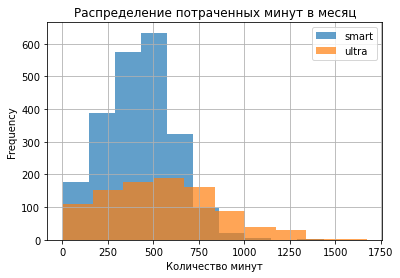

In [78]:
# Сравним распределение в двух тарифах по продолжительности звонков. 
ax = smart.plot(kind='hist', y='call_duration',  linewidth=5, alpha=0.7, label='smart')
ultra.plot(kind='hist', y='call_duration', linewidth=5, alpha=0.7, label='ultra', ax=ax, grid=True, legend=True)
plt.xlabel('Количество минут')
plt.title('Распределение потраченных минут в месяц')
plt.show()

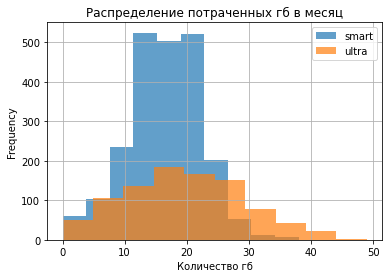

In [79]:
# Сравнение по трафику
ax = smart.plot(kind='hist', y='gb_used', linewidth=5, alpha=0.7, label='smart')
ultra.plot(kind='hist', y='gb_used', linewidth=5, alpha=0.7, label='ultra', ax=ax, grid=True, legend=True)
plt.xlabel('Количество гб')
plt.title('Распределение потраченных гб в месяц')
plt.show()

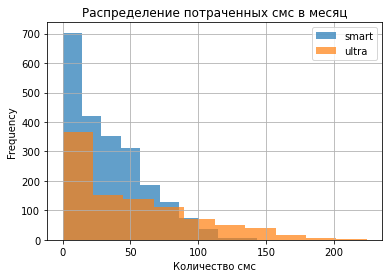

In [80]:
# сравнение по количеству смс 
ax = smart.plot(kind='hist', y='messages_count', linewidth=5, alpha=0.7, label='smart')
ultra.plot(kind='hist', y='messages_count', linewidth=5, alpha=0.7, label='ultra', ax=ax, grid=True, legend=True)
plt.xlabel('Количество смс')
plt.title('Распределение потраченных смс в месяц')
plt.show()

В среднем, пользователи тарифа смарт тратят примерно 420 минут в месяц, а ультра -- 550, пользователи смарт тратят чуть меньше 16 гб, а в ультра -- чуть больше 19, пользователи смарт отправляют в среднем 28 смс, а ультра - 39. 

Если сравнивать среднее и медиану, увидим, что есть скошенность данных: 
- продолжительность звонков: у смарт влево (больше значений с меньшей продолжительностью), а у ультра - вправо (больше значений с большей продолжительностью). 
- гб: смарт, скошенность влево (больше значений с меньшим объемом), ультра -- симметричное распределение 
- смс: скошенность вправо у обоих тарифов, на одном из графиков ниже можно увидеть, что тяготение к нулю, то есть, люди редко отрпавляют смс сейчас. 

# Проверка гипотезы

Выдвинем две гипотезы (обе вдусторонние): 
    1. нулевая: средняя выручка пользователей тарифов «Ультра» и «Смарт» не различается
       альтернативная: средняя выручка пользователей тарифов «Ультра» и «Смарт» различается
    2. нулевая: средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов
       альтернативная: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

In [81]:
df.pivot_table(index='tariff', values='revenue')

,revenue
tariff,
smart,1291.44
ultra,2072.79


In [82]:
len(ultra)

947

In [83]:
len(smart)

2221

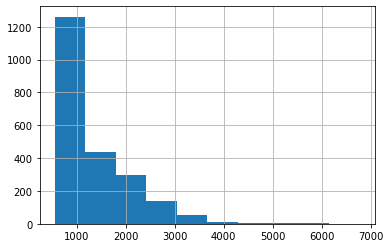

In [84]:
smart['revenue'].hist()

In [85]:
smart.isna().mean()

user_id                  0.00
age                      0.00
churn_date               0.95
city                     0.00
first_name               0.00
last_name                0.00
reg_date                 0.00
tariff                   0.00
month                    0.00
call_duration            0.00
call_count               0.00
mb_used                  0.00
gb_used                  0.00
messages_count           0.00
messages_included        0.00
mb_per_month_included    0.00
minutes_included         0.00
rub_monthly_fee          0.00
rub_per_gb               0.00
rub_per_message          0.00
rub_per_minute           0.00
gb_per_month_included    0.00
extra_calls_price        0.00
extra_messages_price     0.00
extra_gb_price           0.00
revenue                  0.00
city_group               0.00
dtype: float64

In [86]:
smart_revenue=smart['revenue']
smart_revenue1=smart_revenue.dropna()

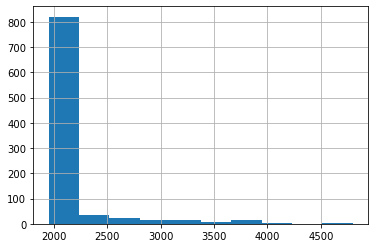

In [87]:
ultra['revenue'].hist()

In [88]:
ultra_revenue=ultra['revenue']
ultra_revenue1=ultra_revenue.dropna()

In [89]:
#smart_revenue=smart['revenue']
#ultra_revenue=ultra['revenue']

alpha = .05 # критический уровень статистической значимости, поставим маленький процент, так как выборка достаточно большая

results = st.ttest_ind(
    smart_revenue1,
    ultra_revenue1, 
    equal_var=False) # выше мы выяснили, что дисперсии выборок не равны, поэтому укажем значение False
print(results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

2.3251854618990201e-243
Отвергаем нулевую гипотезу


Отвергаем основную гипотезу, то есть всё-таки можем утверждать, что разница в доходе между двумя тарифами есть. И больше приносит тариф "ультра". 

In [90]:
df.pivot_table(index=('tariff','city_group'),values='revenue')

revenue
tariff city_group         
smart  Москва      1239.36
       другое      1302.40
ultra  Москва      2074.55
       другое      2072.23

In [91]:
smart_msk=smart.loc[smart['city_group']=='Москва']
smart_msk=smart_msk.dropna()

In [92]:
smart_other=smart.loc[smart['city_group']=='другое']
smart_other=smart_other.dropna()

In [93]:
ultra_msk=ultra.loc[ultra['city_group']=='Москва']
ultra_msk=ultra_msk.dropna()

In [94]:
ultra_other=ultra.loc[ultra['city_group']=='другое']
ultra_other=ultra_other.dropna()

In [95]:
len(smart_msk)

25

In [96]:
len(smart_other)

86

In [97]:
len(ultra_msk)

16

In [98]:
len(ultra_other)

59

In [99]:
smart_msk_revenue=smart_msk['revenue']
smart_other_revenue=smart_other['revenue']

alpha = .1 # критический уровень статистической значимости, поставим процент побольше, так как выборка достаточно
#стала не очень большой

results = st.ttest_ind(
    smart_msk_revenue,
    smart_other_revenue,
    equal_var=False) # проверим гипотезу о равенстве средних двух совокупностей

print(results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

0.17813294868911747
Не получилось отвергнуть нулевую гипотезу


In [100]:
ultra_msk_revenue=ultra_msk['revenue']
ultra_other_revenue=ultra_other['revenue']

alpha = .1 # критический уровень статистической значимости, поставим процент побольше, так как выборка достаточно
#стала не очень большой

results = st.ttest_ind(
    ultra_msk_revenue,
    ultra_other_revenue,
    equal_var=False) # проверим гипотезу о равенстве средних двух совокупностей

print(results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

0.0032538975986644253
Отвергаем нулевую гипотезу


Посмотрим на выборки без разделения на тариф, а только по городу. 

In [101]:
df.pivot_table(index='city_group',values='revenue')

,revenue
city_group,
Москва,1546.05
другое,1517.91


In [102]:
msk_revenue=df.loc[df['city_group']=='Москва']['revenue']
msk_revenue=msk_revenue.dropna()
other_revenue=df.loc[df['city_group']=='другое']['revenue']
other_revenue=other_revenue.dropna()

alpha = .05 # критический уровень статистической значимости, поставим маленький процент, так как выборка достаточно большая

results = st.ttest_ind(
    msk_revenue,
    other_revenue,
    equal_var=False) 

print(results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

0.41435124497027553
Не получилось отвергнуть нулевую гипотезу


Вывод: Если сравнивать два тарифа в целом, то разница в доходах есть, больше у ультра. Если сравнивать по городам, то есть разница в целом между Москвой и другими городами. Если смотреть конкретно по тарифам, то значимая разница есть для тарифа ультра. Пока трудно точно оценить, в какую сторону, но можно предположить, что в Москве доход от ультра выше, чем по другим городам. 

# Обший вывод

В среднем, пользователи тарифа смарт тратят примерно 420 минут в месяц, а ультра -- 550, пользователи смарт тратят чуть меньше 16 гб, а в ультра -- чуть больше 19, пользователи смарт отправляют в среднем 28 смс, а ультра - 39.

Мы также сравнили выборки по двум тарифам и пришли к выводу, что пользователи тарифа "ультра" в Москве могут приносить больше дохода, так что предлагаем направить рекламный бюджет на тариф "ультра" в Москве. 